In [744]:
import os
import csv
import cv2
import time
import glob
import random
import shutil
import numpy as np
import pandas as pd
from skimage import io
from sklearn import metrics
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torchvision
import torchmetrics
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [745]:
os.getcwd()

'/home/huzaifa/workspace/yoga-lab/notebooks'

In [156]:
# import required module
from PIL import Image
  
# get image
filepath = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/resized_train_cropped'

h = []
w = []

for f in os.listdir(filepath):
    img = Image.open(os.path.join(filepath,f))
    # get width and height
    w.append(img.width)
    h.append(img.height)

# print(width,height)

In [157]:
print(max(h),min(h),max(w),min(w))

1051 278 1024 278


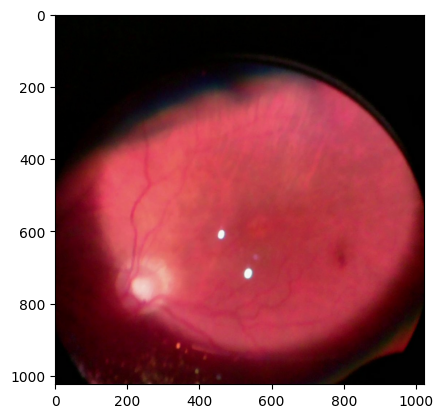

In [158]:
path = '/mnt/ssd_4tb_0/john_wei/raw_data/MRN-0100-OU'
x = plt.imread(path + "/Frame" + "0" + ".jpg")
plt.imshow(x)

In [764]:
test_path = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label/10_left.jpeg'

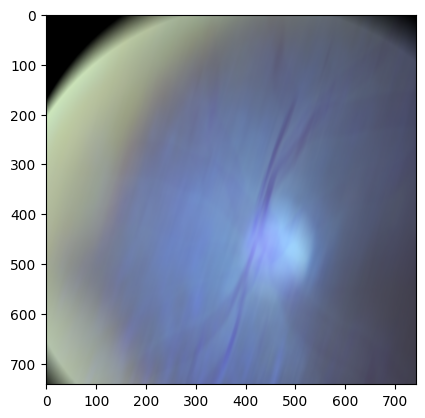

In [800]:
# Load image
img = cv2.imread(test_path)

plt.imshow(img)

x = distort(img)
plt.imshow(x)

In [794]:
def distort(img):
    
    # Motion blur
    blur = [45,60,75,90]
    kernel_size = random.choice(blur)  # Increase for stronger blur
    kernel_direction = np.random.rand(2) - 0.5
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = cv2.warpAffine(kernel, cv2.getRotationMatrix2D((kernel_size/2-0.5, kernel_size/2-0.5), np.arctan2(kernel_direction[1],
                                                             kernel_direction[0])*180/np.pi, 1), (kernel_size, kernel_size))
    kernel = kernel / kernel_size
    motion_blur = cv2.filter2D(img, -1, kernel)

    # Camera glares
    num_glares = random.randint(0,1)  # Increase for more glares
    glare_size = 250  # Increase for larger glares
    for i in range(num_glares):
        x = np.random.randint(0, motion_blur.shape[1] - glare_size)
        y = np.random.randint(0, motion_blur.shape[0] - glare_size)
        a = np.random.randint(glare_size-50, glare_size+50)
        b = np.random.randint(glare_size-100, glare_size)
        theta = np.random.randint(0, 360)
        cv2.ellipse(motion_blur, (x,y), (a,b), theta, 0, 360, (255,255,255), -1)

    # Random crop
    crop_dim = [0.7,0.8,0.9]
    distorted = random_crop(motion_blur, size = (random.choice(crop_dim),random.choice(crop_dim)))
    
    return distorted

In [813]:
def modify_image(img):
    # Apply some modification to the image
    # For example, convert to grayscale
    distorted = distort(img)
    return distorted

# Define input and output folders
input_folder  = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label'
output_folder = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label_distorted'

# # Create output folder if it doesn't exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Iterate over input images
# for filename in os.listdir(input_folder):
#     # Load image
#     img_path = os.path.join(input_folder, filename)
#     img = cv2.imread(img_path)
    
#     # Modify image
#     modified_img = modify_image(img)
    
#     # Generate output filename
#     output_filename = filename[:-5] + '_distorted' + filename[-5:]
#     output_path = os.path.join(output_folder, output_filename)
    
#     # Save modified image
#     cv2.imwrite(output_path, modified_img)

In [838]:
# len(os.listdir('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/resized_train_cropped_distorted'))
len(os.listdir('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label_distorted'))

25802

In [409]:
def move_images(source_folder, destination_folder, csv_file):
    
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Read the CSV file using pandas
    df = pd.read_csv(csv_file)

    # Extract the filenames from the first column of the DataFrame
    filenames = df.iloc[:, 0]

    # Iterate through each filename
    for filename in filenames:
        # Check if the file exists in the source folder
        src_file = os.path.join(source_folder, filename+'_distorted.jpeg')
        if os.path.exists(src_file):
            # Move the file to the destination folder
            dst_file = os.path.join(destination_folder, filename+'_distorted.jpeg')
            shutil.move(src_file, dst_file)

In [410]:
# src_path = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/resized_train_cropped_distorted'
# dest_path = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/resized_train_cropped_0_label_distorted'
# csv_file = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/trainLabels_cropped_label0.csv'

# move_images(src_path,dest_path,csv_file)

# print(len(os.listdir(dest_path)))

# Kaggle Notebook Code

In [820]:
# seed function
def seed_everything(seed = 23):
    # tests
    assert isinstance(seed, int), 'seed has to be an integer'
    
    # randomness
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [821]:
image_size = 244
#IMAGE PREPROCESSING

def prepare_image(path,
                  root_dir,
                  sigmaX         = 10, 
                  do_random_crop = False):
    
    '''
    Preprocess image
    '''
    
    # import image
    image = cv2.imread(os.path.join(root_dir,path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

In [841]:
def prepare_image_goodbad(path,
                          root_dir,
                          sigmaX         = 10, 
                          do_random_crop = False):
    
    '''
    Preprocess image
    '''
    
    # import image
    image = cv2.imread(os.path.join(root_dir,path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform crops
    if image.shape[1] == 2560:
        image = image[75:1365, 635:1925, :]
    elif image.shape[1] == 2160:
        image = image[:, 360:1800, :]
    elif image.shape[1] == 2256:
        image = image[155:, 484:1774, :]
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
#     image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

In [823]:
#CROP FUNCTIONS

def crop_black(img, 
               tol = 7):
    
    '''
    Perform automatic crop of black areas
    '''
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img

In [824]:
def circle_crop(img, 
                sigmaX = 10):   
    
    '''
    Perform circular crop around image center
    '''
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img 

In [825]:
def random_crop(img, 
                size = (0.9, 1)):
    
    '''
    Random crop
    '''

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

In [870]:
class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, root_dir, transform = None, do_random_crop = True, itype = '.png'):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
        self.name2label = {}
        for name in sorted(os.listdir(os.path.join(root_dir))):
            if not os.path.isdir(os.path.join(root_dir, name)):
                continue
            # len(..) returns from 0 - n based on saved labels so far
            self.name2label[name] = len(self.name2label.keys())
        print('labels: ',self.name2label)  
        # image, label, helper function load_csv()
        self.images, self.labels = self.load_csv('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/distorted.csv')
        
    # length
    def __len__(self):
#         return len(self.data)
#         print(len(self.images))
        return len(self.images)
    
    # get items    
#     def __getitem__(self, idx):
#         img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + self.itype)
#         image    = prepare_image(img_name, do_random_crop = self.do_random_crop)
#         image    = self.transform(image)
#         label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
#         return {'image': image, 'label': label}
    
    def __getitem__(self,index):
        img, label = self.images[index], self.labels[index]
        image = prepare_image(img, self.root_dir, do_random_crop = self.do_random_crop)
        label = torch.tensor(label)
        image = self.transform(image)
        return {'image': image, 'label': label}
    
    def load_csv(self,filename):
        # if no .csv, create; else load
        if not os.path.exists(filename):
            print('loading...')
            images = []
            for name in self.name2label.keys():
                images += glob.glob(os.path.join(self.root_dir, name, '*.png'))
                images += glob.glob(os.path.join(self.root_dir, name, '*.jpg'))
                images += glob.glob(os.path.join(self.root_dir, name, '*.jpeg'))
#                 images += glob.glob(os.path.join(self.root_dir, name))
            print('images: ',len(images))
            random.shuffle(images)  
            with open(filename, mode='w', newline='') as f:
                writer = csv.writer(f)
                for img in images:
                    print('img: ',img)
                    name = img.split(os.sep)[-2]
#                     print('name: ',name)
                    label = self.name2label[name]
                    # 'pokemon\\bulbasaur\\00000000.png', 0
                    writer.writerow([img, label])
                print(f"written into csv file: {filename}")       
        # read from csv file
        images, labels = [], []
        with open(filename) as f:
            reader = csv.reader(f)
            for row in reader:
                # 'pokemon\\bulbasaur\\00000000.png', 0
                img, label = row
                label = int(label)
                images.append(img)
                labels.append(label)       
        assert len(images) == len(labels)
        return images, labels

In [827]:
#GPU CHECK
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [629]:
#RANDOMNESS

seed = 23
seed_everything(seed)

In [535]:
# # import data
# train = pd.read_csv('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/trainLabels_cropped_label0_final.csv')
# train.columns = ['id_code','diagnosis']
# # train.columns = ['temp0','temp1','id_code', 'diagnosis','disease']
# # test = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

# # check shape
# print(train.shape)
# # print(train.shape, test.shape)
# print('-' * 15)
# print(train['diagnosis'].value_counts())
# print('-' * 15)
# # print(test['diagnosis'].value_counts())

In [871]:
#TRANSFORMATIONS

# parameters
batch_size = 16
image_size = 244

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

In [872]:
# x = pd.DataFrame(os.listdir('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label'))
# y = pd.DataFrame(os.listdir('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label_distorted'))   

# x = x.rename(columns = {0:'image'})
# x['distorted'] = 0
# y = y.rename(columns = {0:'image'})
# y['distorted'] = 1

# x['image'] = 'resized_train_cropped_0_label/'+x['image']
# y['image'] = 'resized_train_cropped_0_label_distorted/'+y['image']
# # x.head()
# y.head()

# xy = pd.concat([x,y],axis=0)

# xy.shape

# xy.to_csv('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_cropped_goodbad.csv')

In [873]:
# in_file = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_cropped_goodbad.csv'
# out_file = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_cropped_goodbad_final.csv'

# # Open the input and output CSV files
# with open(in_file, 'r') as input_file, open(out_file, 'w', newline='') as output_file:
#     # Read the input CSV file into a list of rows
#     reader = csv.reader(input_file)
#     rows = [row for row in reader]

#     # Shuffle the list of rows
#     random.shuffle(rows)

#     # Write the shuffled list of rows to the output CSV file
#     writer = csv.writer(output_file)
#     writer.writerows(rows)

In [882]:
#EXAMINE FIRST BATCH (TRAIN)

# get dataset
distorted_data = EyeData(data    = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_cropped_goodbad_final.csv', 
                      root_dir   = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0',
                      transform  = train_trans,
                      itype      = '.jpeg')

# data loader
data_len = ( len(os.listdir('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label_distorted')) +
             len(os.listdir('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/label_0/resized_train_cropped_0_label')) )
train_test_ratio = 0.8
train_len = int(data_len*train_test_ratio)
test_len = data_len - train_len

train_set,test_set = torch.utils.data.random_split(distorted_data,[train_len,test_len])

distorted_loader_train = DataLoader(dataset=train_set, batch_size=batch_size_dr, shuffle=True, num_workers=4)
distorted_loader_test = DataLoader(dataset=test_set, batch_size=batch_size_dr, shuffle=True, num_workers=4)

labels:  {'resized_train_cropped_0_label': 0, 'resized_train_cropped_0_label_distorted': 1}


/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

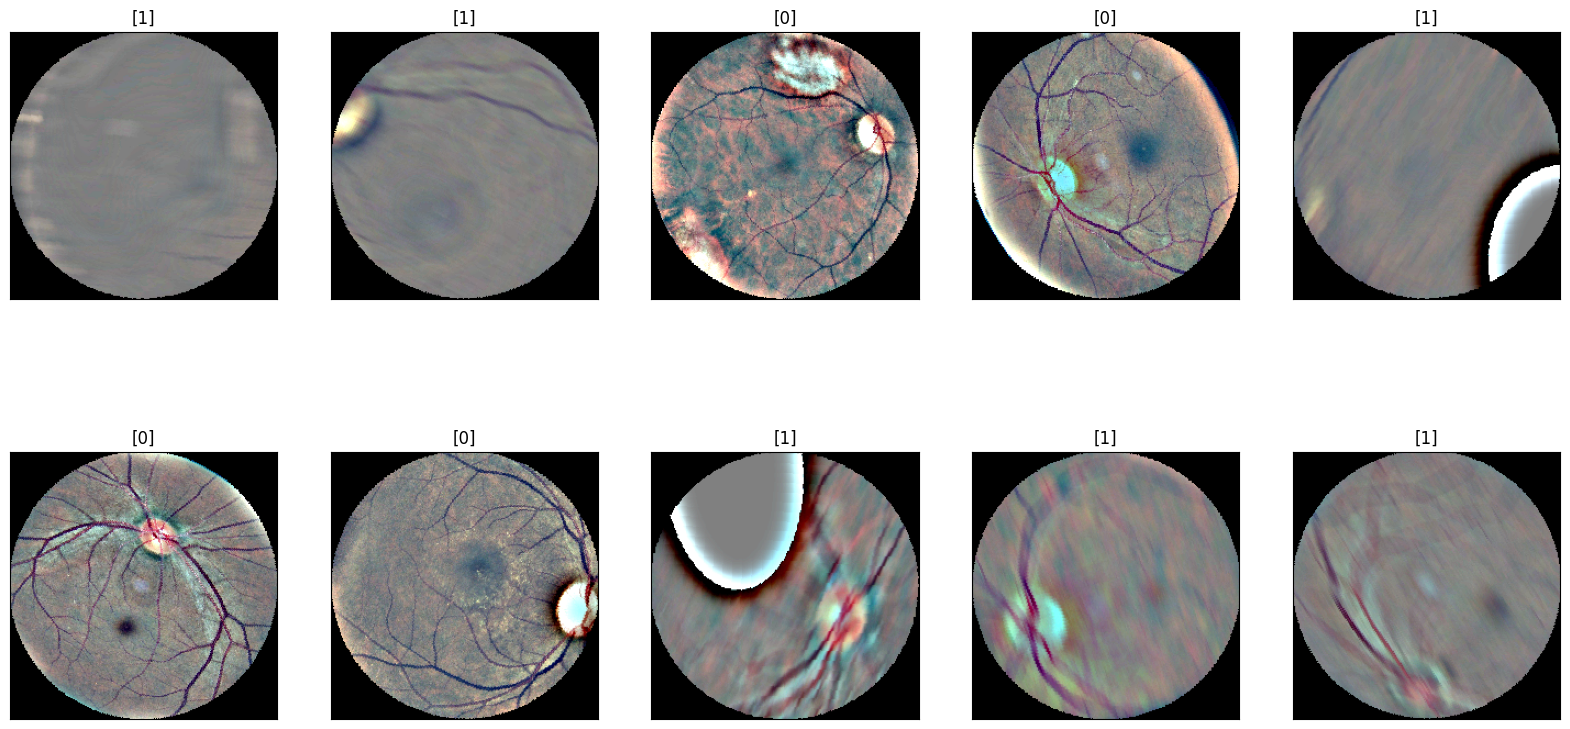

In [881]:
# display images
for batch_i, data in enumerate(distorted_loader_train):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

# Main Code

#### Hyperparameters

In [883]:
# Diabetic Retinpathy
num_classes_dr = 2 # Changed to binary problem
lr_init_dr = 1e-5
batch_size_dr = 128
num_epochs_dr = 5
weight_decay_dr = 1 # Regularization parameter

# Good vs Bad
num_classes_gb = 2
lr_init_gb = 1e-7
batch_size_gb = 64
num_epochs_gb = 150
weight_decay_gb = 1e-2 # Regularization parameter

#### Create Dataloaders

In [488]:
# Function to compute mean and st dev of batches

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)
    i = 0

    for images, _ in loader:
        print(i)
        i+=1
        if i == 10:
            break
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std

In [539]:
# # Class to load diabetic retinopathy data, and john good vs bad data

# class DiaRetDataset(Dataset):
    
#     def __init__(self, csv_file, root_dir, transform=None):
#         self.annotations = pd.read_csv(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.annotations)
    
#     def __getitem__(self,index):
#         img_path = os.path.join(self.root_dir,self.annotations.iloc[index,2]+'.jpeg')
#         image = io.imread(img_path)
#         label = torch.tensor(int(self.annotations.iloc[index,4]))
        
#         if self.transform:
#             image = self.transform(image)
            
#         return (image,label)

In [731]:
# Class to load good vs bad data

class GoodBadDataset(Dataset):
    
    def __init__(self, root_dir, transform=None, do_random_crop = True, itype = '.png'):
        self.root_dir = root_dir
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
        self.name2label = {}
        
        for name in sorted(os.listdir(os.path.join(root_dir))):
            if not os.path.isdir(os.path.join(root_dir, name)):
                continue
            # len(..) returns from 0 - n based on saved labels so far
            temp = len(self.name2label.keys())
            if temp == 0 : self.name2label[name] = 1
            else: self.name2label[name] = 0
        print(self.name2label)
        # image, label, helper function load_csv()
        self.images, self.labels = self.load_csv('/mnt/ssd_4tb_0/huzaifa/good_bad/images.csv')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img, label = self.images[index], self.labels[index]
        
#         image = io.imread(img)
        label = torch.tensor(label)
        img, label = self.images[index], self.labels[index]
        image = prepare_image_goodbad(img, self.root_dir, do_random_crop = self.do_random_crop)
        image = image.float()
        label = torch.tensor(label)
        return {'image': image, 'label': label}
    
    def load_csv(self,filename):
        # if no .csv, create; else load
        if not os.path.exists(filename):
            images = []
            for name in self.name2label.keys():
                images += glob.glob(os.path.join(self.root_dir, name, '*.png'))
                images += glob.glob(os.path.join(self.root_dir, name, '*.jpg'))
                images += glob.glob(os.path.join(self.root_dir, name, '*.jpeg'))

            print(len(images), images)
            random.shuffle(images)
            
            with open(filename, mode='w', newline='') as f:
                writer = csv.writer(f)
                for img in images:
                    name = img.split(os.sep)[-2]
                    label = self.name2label[name]
                    # 'pokemon\\bulbasaur\\00000000.png', 0
                    writer.writerow([img, label])
                print(f"written into csv file: {filename}")
                
        # read from csv file
        images, labels = [], []
        with open(filename) as f:
            reader = csv.reader(f)
            for row in reader:
                # 'pokemon\\bulbasaur\\00000000.png', 0
                img, label = row
                label = int(label)
                images.append(img)
                labels.append(label)
                
        assert len(images) == len(labels)
        return images, labels

In [690]:
# # Creating dataloaders - diabetic retinopathy

# # mean and std: tensor([0.4238, 0.3027, 0.2246]) tensor([0.2859, 0.2133, 0.1812])
# transform_diaret = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224,224))
# ])

# data_len = len(os.listdir('/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/resized_train_cropped'))
# train_test_ratio = 0.8
# train_len = int(data_len*train_test_ratio)
# test_len = data_len - train_len

# dataset = DiaRetDataset(csv_file = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/trainLabels_cropped_binary.csv',
#                         root_dir = '/mnt/ssd_4tb_0/huzaifa/retina_kaggle/resized_train_cropped/resized_train_cropped',
#                         transform = transform_diaret)

# train_set,test_set = torch.utils.data.random_split(dataset,[train_len,test_len])

# trainloader_dr = DataLoader(dataset=train_set, batch_size=batch_size_dr, shuffle=True, num_workers=4)
# testloader_dr = DataLoader(dataset=test_set, batch_size=batch_size_dr, shuffle=True, num_workers=4)

# # loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=8)

# # mean_dr, std_dr = batch_mean_and_sd(loader)

# # print("mean and std: \n", mean_dr, std_dr)

In [732]:
# Creating dataloaders - good vs bad

# mean and std: tensor([0.2032, 0.0976, 0.1154]) tensor([0.2341, 0.1281, 0.1466])
transform_goodbad = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Resize((224,224))
])

data_len = ( len(os.listdir('/home/john/mayo_summer/OLD_image_good_vs_bad/good')) +
             len(os.listdir('/home/john/mayo_summer/OLD_image_good_vs_bad/bad')) )
train_test_ratio = 0.8
train_len = int(data_len*train_test_ratio)
test_len = data_len - train_len

dataset = GoodBadDataset(root_dir = '/home/john/mayo_summer/OLD_image_good_vs_bad',
                        transform = transform_goodbad)

train_set_gb,test_set_gb = torch.utils.data.random_split(dataset,[train_len,test_len])

trainloader_gb = DataLoader(dataset=train_set_gb, batch_size=10, shuffle=True, num_workers=4)
testloader_gb = DataLoader(dataset=test_set_gb, batch_size=batch_size_gb, shuffle=True, num_workers=4)

{'bad': 1, 'good': 0}


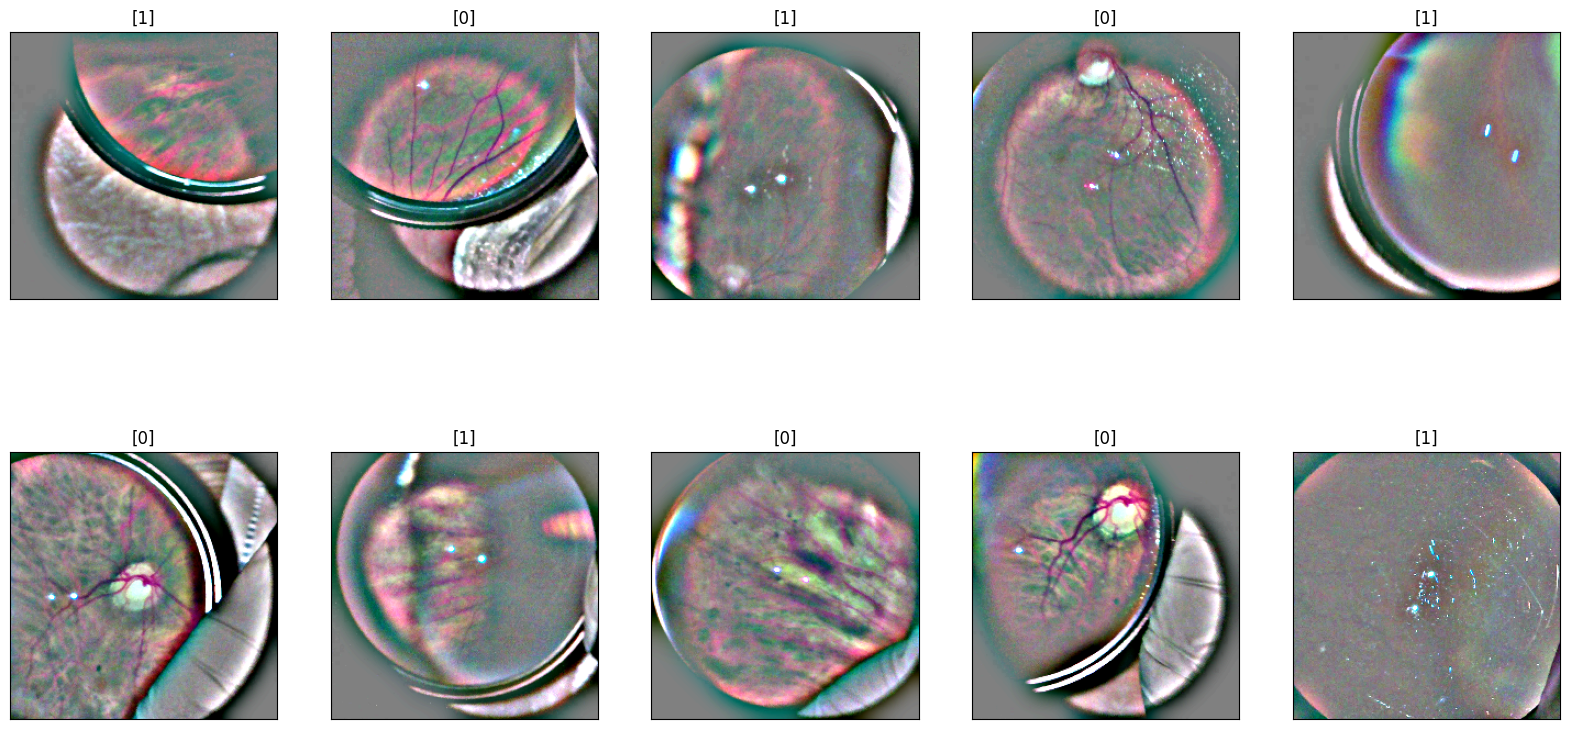

In [708]:
# display images
for batch_i, data in enumerate(trainloader_gb):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

#### Evaluation code

In [613]:
# Function to evaluate updated model after each epoch

def run_test(net, testloader, criterion, task):
    
    correct = 0
    loss_final = 0
    total = 0
    avg_test_loss = 0.0

    with torch.no_grad():
#         for imgs_gb, imgs_dr, dr_label, gb_label in testloader:
#             if task == 'diab_ret':
#                 images, labels = imgs_dr.to(device), dr_label.to(device)
#             elif task == 'goodbad':
#                 images, labels = imgs_gb.to(device), gb_label.to(device)

#         for img, label in testloader:
#             images, labels = img.to(device), label.to(device)
        for data in testloader:
            images, labels = data['image'].to(device), data['label'].to(device)
            
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
#             print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
#             loss_final += criterion(outputs, labels).item()
            
    print('TESTING:')
    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the test images: {avg_test_loss:.3f}\n')
    
    test_acc = np.round((100*correct)/total,2)
    
    return labels, predicted, avg_test_loss.item(), test_acc

#### Adjust learning rate code

In [540]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """
    Sets the learning rate to the initial LR decayed by 10 every 30 epochs
    """
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Create training instance

In [619]:
# Function to train model for given epochs, lr, and task (diabetic retinopathy or good vs bad)

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task, print_freq):

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    # setting train and test loaders
    if task == 'diaret':
        trainloader = trainloader_dr
        testloader = testloader_dr
    elif task == 'goodbad':
        trainloader = trainloader_gb
        testloader = testloader_gb
    elif task == 'distort':
        trainloader = distorted_loader_train
        testloader = distorted_loader_test
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        # Running metrics, reset once printed after every few mini batches (defined below)
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        
        # Total metrics
        loss_final = 0.0
        avg_loss_final = 0.0
        total_final = 0.0
        correct_final = 0.0
        
        start_time = time.time()
        
        net.train()

        for i, data in enumerate(trainloader, 0):
        
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            images, labels = data['image'].to(device), data['label'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Getting predicted results
            _, predicted = torch.max(outputs.data, 1)
            
            # Print statistics
#             print_freq = 100
            running_loss += loss.item()
#             loss_final += loss.item()
            avg_loss_final += loss.item()  / len(trainloader)

            # Calculate acc
            running_total += labels.size(0)  
            total_final += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            correct_final += (predicted == labels).sum().item()
            
            if i % print_freq == (print_freq - 1):    # print every 100 mini-batches
                print(f'[epoch {epoch + 1}, batch {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # Append train loss and accuracy to list
#         train_loss.append(loss_final/total_final)
        train_loss.append(avg_loss_final)
        train_acc.append(np.round((100*correct_final)/total_final,2))
        
        # Running the run_test() function after each epoch; Setting the model to the evaluation mode.
        net.eval()
        _, _, test_loss_epoch, test_acc_epoch = run_test(net, testloader, criterion, task)

        # Append test loss and accuracy to list        
        test_loss.append(test_loss_epoch)
        test_acc.append(test_acc_epoch)
        
    print('Finished Training')
    
    return train_loss, train_acc, test_loss, test_acc

#### Import pretrained resnet (2 classes)

In [580]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [570]:
# Function to set last 2 layers trainable, freeze rest of the model

def set_parameter_requires_grad(model):
  
  for name, module in model.named_children():
    if name in ['layer4','fc']:
        for _, para in module.named_parameters():
            para.requires_grad = True
    else:
        for _, para in module.named_parameters():
            para.requires_grad = False

In [571]:
def initialize_model(num_classes, freeze_layers=True, feature_extract=False, use_pretrained=True):

    """
    Initialize the model for this run
    Inputs:
        num_classes: The number of classes that the model will be trained on
        freeze_layers: If True, unfreeze the last two layers and freeze the rest 
        feature_extract: Whether or not to use feature extraction or fine-tuning. Default is False, we fine tune the whole model
        use_pretrained: Whether or not to use a pretrained model
    Outputs:
        model_ft: The model to be used as per the desired number of output classes
    """

    model_ft = None
    model_ft = torchvision.models.resnet18(pretrained = use_pretrained)
    if freeze_layers is True:
        set_parameter_requires_grad(model_ft)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    return model_ft

In [572]:
# Setting the environment variable to store pretrained model
# os.environ['TORCH_HOME'] = 'models\\resnet'
os.environ['TORCH_HOME'] = '/mnt/ssd_4tb_0/huzaifa/models/resnet'

#### Initialize model

In [884]:
net = initialize_model(num_classes_dr, freeze_layers=False, feature_extract=False, use_pretrained=True)
net = net.to(device)

In [885]:
# Print all the trainable parameters
# params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [886]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Train for diabetic retinopathy (train all layers)

In [887]:
# Defining loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, weight_decay = weight_decay_dr)

In [888]:
train_loss, train_acc, test_loss, test_acc = train(net, criterion, optimizer, num_epochs=num_epochs_dr,
                                                   decay_epochs=10,init_lr=lr_init_dr, task='distort',print_freq=100)

/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

[epoch 1, batch   100] loss: 0.469 acc: 83.43 time: 226.47
[epoch 1, batch   200] loss: 0.289 acc: 97.91 time: 225.99
[epoch 1, batch   300] loss: 0.214 acc: 99.02 time: 226.12


/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

TESTING:
Accuracy of the network on the test images: 99.47 %
Average loss on the test images: 0.168



/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

[epoch 2, batch   100] loss: 0.158 acc: 99.58 time: 228.73
[epoch 2, batch   200] loss: 0.130 acc: 99.59 time: 225.65
[epoch 2, batch   300] loss: 0.108 acc: 99.70 time: 225.62


/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

TESTING:
Accuracy of the network on the test images: 99.83 %
Average loss on the test images: 0.088



/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

[epoch 3, batch   100] loss: 0.087 acc: 99.81 time: 227.15
[epoch 3, batch   200] loss: 0.076 acc: 99.79 time: 226.77
[epoch 3, batch   300] loss: 0.065 acc: 99.77 time: 226.10


/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

TESTING:
Accuracy of the network on the test images: 99.93 %
Average loss on the test images: 0.055



/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

[epoch 4, batch   100] loss: 0.057 acc: 99.82 time: 227.20
[epoch 4, batch   200] loss: 0.050 acc: 99.87 time: 225.20
[epoch 4, batch   300] loss: 0.047 acc: 99.88 time: 226.13


/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

TESTING:
Accuracy of the network on the test images: 99.95 %
Average loss on the test images: 0.040



/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

[epoch 5, batch   100] loss: 0.041 acc: 99.88 time: 226.89
[epoch 5, batch   200] loss: 0.039 acc: 99.81 time: 225.77
[epoch 5, batch   300] loss: 0.035 acc: 99.91 time: 225.88


/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

TESTING:
Accuracy of the network on the test images: 99.97 %
Average loss on the test images: 0.029

Finished Training


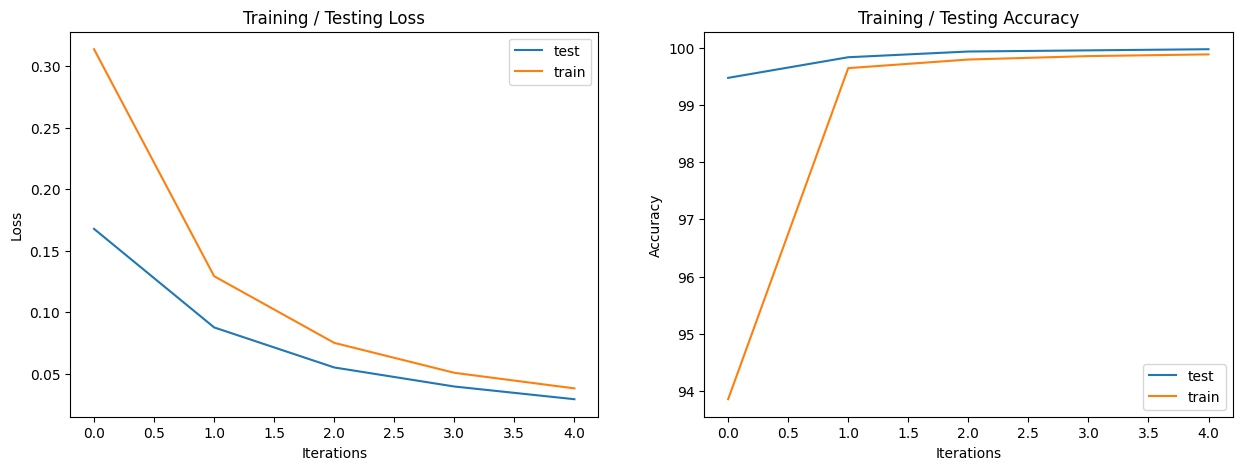

In [889]:
# Plot loss and accuracy

# Initialize plots
fig,ax = plt.subplots(1,2,figsize=(15,5))

# Set titles and axis labels
ax[0].set_title("Training / Testing Loss")
ax[1].set_title("Training / Testing Accuracy")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Accuracy")

# Plot
ax[0].plot(test_loss,label="test")
ax[0].plot(train_loss,label="train")
ax[1].plot(test_acc,label="test")
ax[1].plot(train_acc,label="train")

# Show legends
ax[0].legend()
ax[1].legend()

#### Save model

In [890]:
MODEL_SAVE_PATH = '/mnt/ssd_4tb_0/huzaifa/models/resnet_distort_v2.pth'
torch.save(net.state_dict(), MODEL_SAVE_PATH)

In [645]:
# Testing if model only outputs all 0's

test_path = '/mnt/ssd_4tb_0/huzaifa/models/resnet_distort_v1.pth'

net_test = initialize_model(num_classes=2, freeze_layers=True, feature_extract=False, use_pretrained=True)
net_test.load_state_dict(torch.load(test_path))

net_test.eval()

net_test = net_test.to(device)

label,pred,loss,acc = run_test(net_test, distorted_loader_test, criterion, task='distort')

/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/user/miniconda/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: Typed

TESTING:
Accuracy of the network on the test images: 99.80 %
Average loss on the test images: 0.017



/home/user/miniconda/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


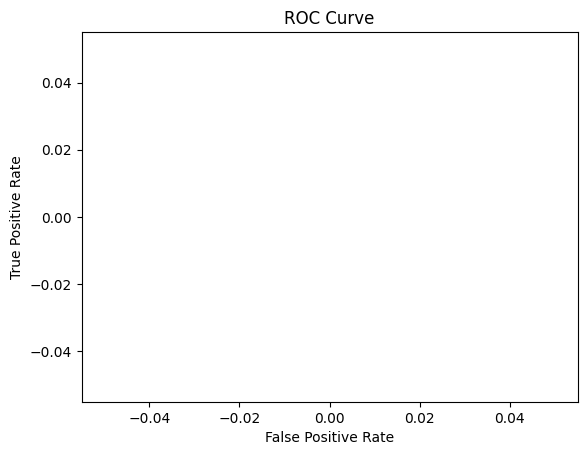

In [722]:
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(torch.Tensor.cpu(label), torch.Tensor.cpu(pred), pos_label=1)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auroc = torchmetrics.AUROC(task="binary")
a = auroc(pred,label)
print(f'AUROC: {a}')

#### Load model

In [733]:
net_gb = initialize_model(num_classes=2, freeze_layers=True, feature_extract=False, use_pretrained=True)
net_gb.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Replace fc layer for good/bad classification
num_features = net_gb.fc.in_features
net_gb.fc = nn.Linear(num_features, num_classes_gb)

net_gb = net_gb.to(device)

#### Freeze layers of model

In [734]:
set_parameter_requires_grad(net_gb)

In [735]:
# Print all the trainable parameters

print("Params to learn:")
params_to_update = []
for name,param in net_gb.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


#### Train for good vs bad (train head only)

In [736]:
criterion_gb = nn.CrossEntropyLoss()
optimizer_gb = optim.Adam(params_to_update, weight_decay = weight_decay_gb)

In [737]:
train_loss_gb, train_acc_gb, test_loss_gb, test_acc_gb = train(net_gb, criterion_gb, optimizer_gb,
                                                               num_epochs=num_epochs_gb, decay_epochs=10,
                                                               init_lr=lr_init_gb, task='goodbad', print_freq = 2)

[epoch 1, batch     2] loss: 0.928 acc: 40.00 time: 1.17
[epoch 1, batch     4] loss: 0.862 acc: 45.00 time: 0.08
[epoch 1, batch     6] loss: 0.859 acc: 40.00 time: 0.63
[epoch 1, batch     8] loss: 0.820 acc: 45.00 time: 0.08
[epoch 1, batch    10] loss: 0.671 acc: 60.00 time: 0.73
[epoch 1, batch    12] loss: 1.055 acc: 30.00 time: 0.08
TESTING:
Accuracy of the network on the test images: 57.58 %
Average loss on the test images: 0.862

[epoch 2, batch     2] loss: 0.904 acc: 40.00 time: 1.44
[epoch 2, batch     4] loss: 0.704 acc: 55.00 time: 0.01
[epoch 2, batch     6] loss: 0.785 acc: 50.00 time: 0.73
[epoch 2, batch     8] loss: 0.869 acc: 50.00 time: 0.02
[epoch 2, batch    10] loss: 0.946 acc: 40.00 time: 0.71
[epoch 2, batch    12] loss: 0.872 acc: 45.00 time: 0.01
TESTING:
Accuracy of the network on the test images: 57.58 %
Average loss on the test images: 0.802

[epoch 3, batch     2] loss: 0.853 acc: 50.00 time: 1.17
[epoch 3, batch     4] loss: 0.741 acc: 55.00 time: 0.07


KeyboardInterrupt: 

In [ ]:
# Plot loss and accuracy

# Initialize plots
fig,ax = plt.subplots(1,2,figsize=(15,5))

# Set titles and axis labels
ax[0].set_title("Training / Testing Loss")
ax[1].set_title("Training / Testing Accuracy")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Accuracy")

# Plot
ax[0].plot(test_loss_gb,label="test")
ax[0].plot(train_loss_gb,label="train")
ax[1].plot(test_acc_gb,label="test")
ax[1].plot(train_acc_gb,label="train")

# Show legends
ax[0].legend()
ax[1].legend()

In [727]:
net_gb.eval()

net_gb = net_gb.to(device)

label,pred,loss,acc = run_test(net_gb, testloader_gb, criterion_gb, task='goodbad')

TESTING:
Accuracy of the network on the test images: 63.64 %
Average loss on the test images: 0.629



In [728]:
pred

tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')

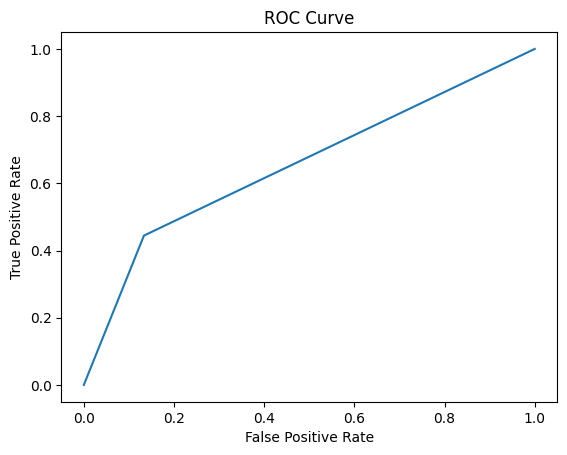

AUROC: 0.6555555462837219


In [729]:
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(torch.Tensor.cpu(label), torch.Tensor.cpu(pred), pos_label=1)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auroc = torchmetrics.AUROC(task="binary")
a = auroc(pred,label)
print(f'AUROC: {a}')